::: {.hidden}
$$
\newcommand{\R}{\mathbb{R}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vz}{\mathbf{z}}
\newcommand{\vd}{\mathbf{d}}
\newcommand{\mX}{\mathbf{X}}
\newcommand{\mR}{\mathbf{R}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\vr}{\mathbf{r}}
\newcommand{\vzero}{\mathbf{0}}
\newcommand{\bracket}[1]{\langle #1 \rangle}
\newcommand{\paren}[1]{\left( #1 \right)}
\newcommand{\one}[1]{\mathbb{1}\left[ #1 \right]}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\cD}{\mathcal{D}}
\newcommand{\cM}{\mathcal{M}}
\newcommand{\mA}{\mathbf{A}}
\newcommand{\vtheta}{\boldsymbol{\theta}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\lvert #1 \rvert}
\newcommand{\prob}[1]{\mathbb{P}\left[#1\right]}
\newcommand{\E}{\mathbb{E}}
\newcommand{\dd}[2]{\frac{\partial #1}{\partial #2}}

\usepackage{amsmath}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

In [24]:
#| echo: false
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

:::

# Quick Recap

Last time, we considered the problem of *empirical risk minimization* with a *convex* loss function. We assumed that we had data, a pair $(\mX, \vy)$ where 

- $\mX \in \R^{n\times p}$ is the *feature matrix*. There are $n$ distinct observations, encoded as rows. Each of the $p$ columns corresponds to a *feature*: something about each observation that we can measure or infer. Each observation is written $\vx_1, \vx_2,\ldots$. 
$$
\mX = \left[\begin{matrix} & - & \vx_1 & - \\ 
& - & \vx_2 & - \\ 
& \vdots & \vdots & \vdots \\ 
& - & \vx_{n} & - \end{matrix}\right]
$$
- $\vy \in \R^{n}$ is the *target vector*. The target vector gives a label, value, or outcome for each observation. 

Using this data, we defined the empirical risk minimization problem, which had the general form 
$$
\hat{\vw} = \argmin_{\vw} \; L(\vw)\;, 
$${#eq-empirical-risk-minimization}
where 
$$
L(\vw) = \frac{1}{n} \sum_{i = 1}^n \ell(f_{\vw}(\vx_i), y_i)\;.
$$

Here, $f_{\vw}:\R^p \rightarrow \R$ is our predictor function, which takes in a feature vector $\vx_i$ and spits out a prediction $\hat{y}_i$. We are still assuming that $f_{\vw}$ is linear and therefore has the form 

[Originally we considered classifiers of the form $f_{\vw, b}(\vx) = \bracket{\vw, \vx} - b$, but we can ignore $b$ for today by using the assumption that the final column of $\vx$ is a column of $1$s, just like we did for the perceptron.]{.aside}
$$
f_{\vw}(\vx) = \bracket{\vw, \vx}
$${#eq-linear-predictor}

In our [last lecture](gradient-descent.qmd), we studied how to compute the gradient of $L(\vw)$ in minimize the convex loss and find a good value $\hat{\vw}$ for the parameter vector. In this lecture we're going to assume that we can cheerfully solve the empirical risk minimization for convex linear models. This time, we're going to see how we can use the framework of convex linear models to try to get around one of the main limitations we've seen in class so far: our models only work with linear decision boundaries. Most of the data we care about has *nonlinear* decision boundaries. Here's a dramatic example. For this example, I'm using the implementation of logistic regression from `scikit-learn`. I'm also using the `plot_decision_regions` function from the `mlxtend` package, which is a handy plotting utility for visualizing the behavior of our models. 

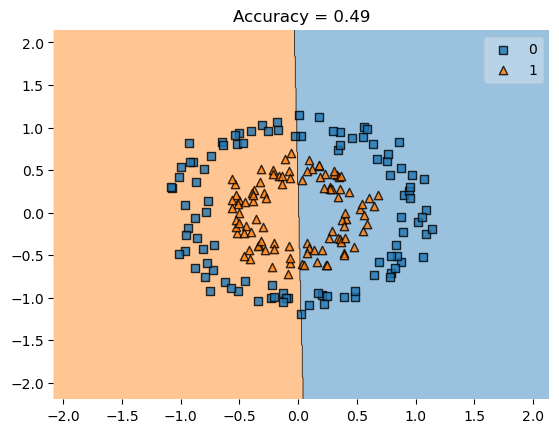

In [25]:
from sklearn.datasets import make_moons, make_circles
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import numpy as np
np.seterr(all="ignore")

X, y = make_circles(200, shuffle = True, noise = 0.1, factor = 0.5)

LR = LogisticRegression()
LR.fit(X, y)
plot_decision_regions(X, y, clf = LR)
score = plt.gca().set_title(f"Accuracy = {LR.score(X, y)}")

Yikes! Our accuracy isn't much better than 50%. 

Visually this *should* be pretty easy data to classify. But the linear decision boundary isn't the way. 

::: {.callout-important}

Given a point $\vx$, what information would you find most useful about that point in determining whether it should have label $0$ or $1$ based on this training data? 
:::

## Feature Maps

Suppose that we were able to extract from each point its distance from the origin. In 2d, we could take a point $\vx$ and simply compute 

$$
r^2 = x_1^2 + x_2^2\;. 
$$

We could then make the classification based on the value of $r^2$. In this data set, it looks like the classification rule that predicts $1$ if $r^2 < 1$ and $0$ otherwise would be a pretty good one. The important insight here is that this is *also* a linear model, with linear predictor function 

$$
\hat{y} = \bracket{\vr, \vw}\;,
$$

and predicted labels $\mathbb{1}[\hat{y} < 0]$. 

where $\vr = (r^2, 1)$ and $\vw = (1, -1)$. This means that we can use empirical risk minimization for this problem if we just transform the features $\mX$ first! We need to compute a matrix $\mR$ whose $i$th row is $\vr_i = (r^2_i, 1) = (x_{i1}^2 + x_{i2}^2, 1)$, and then use this matrix in place of $\mX$ for our classification task. 

The transformation $(x_1, x_2) \mapsto (x_1^2 + x_2^2, 1)$ is an example of a *feature map*. 

::: {.callout-note}
::: {#def-feature-map}

A *feature map* $\phi$ is a function $\phi:D \rightarrow \R^p$, where $D$ is the set of possible data values. If $d\in D$ is a data point, we call $\phi(d) = \vx \in \R^p$ the *feature vector* corresponding to $d$.  For a given feature map $\phi$, we define the map $\Phi:D^n \rightarrow \R^{n\times p}$ as 

$$
\Phi(\vd) = \left(\begin{matrix}
     - & \phi(d_1) & - \\
     - & \phi(d_2) & - \\
     \vdots & \vdots & \vdots \\
     - & \phi(d_n) & - \\
\end{matrix}\right)
$$

We'll often write 

$$
\mX = \Phi(\vd)
$$

to say that $\mX$ is the feature matrix for a data set $\vd$. 

:::
:::

We can think of feature maps in two ways: 

Feature maps can represent **measurement processes**. For example, maybe I am trying to classify penguins by species, based on physiological measurements. The *real data* is the penguin, and the measurements are how I represent that penguin with numbers. In this case, I might write my feature map as 
$$\phi(🐧) = (\mathrm{height}, \mathrm{weight}, \text{bill length})$$
Here, $D$ is a set of many penguins $D = \{🐧_1, 🐧_2, 🐧_3, 🐧_4, 🐧_5, 🐧_6, 🐧_7\}$, and $d\in D$ is a specific penguin. 
The process of transforming an object into a vector via a feature map is often called **vectorization** as well, especially in the context of representing digital data as vectors. We often talk about vectorizing text and images for example; this can be done using feature maps. 

Feature maps can also represent **data processing**, which is more like our example above. There, we're taking some data that's already a vector and turning it into a DIFFERENT vector that we think will be helpful for our learning task. 

## Feature Maps and Linear Separability

We often think of feature maps as taking us from a space in which the data is **not** linearly separable to a space in which it is. For example, consider the feature map 

$$
(x_1, x_2) \maps_to (x_1^2, x_2^2)\;. 
$$

This map is sufficient to express the radius information, since we can represent the radius as 

$$
r^2 = \bracket{(1, 1), (x_1^2, x_2^2)}\;.
$$

Let's see how this looks. We'll again show the failed linear separator, and we'll also show a successful separator in a transformed feature space: 

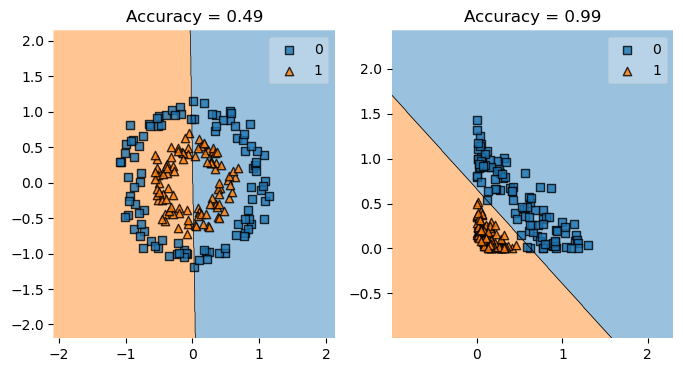

In [29]:
fig, axarr = plt.subplots(1, 2, figsize=(8, 4))

plot_decision_regions(X, y, clf = LR, ax = axarr[0])
score = axarr[0].set_title(f"Accuracy = {LR.score(X, y)}")

X_ = X**2
LR2 = LogisticRegression()
LR2.fit(X_, y)
plot_decision_regions(X_, y, clf = LR2, ax = axarr[1])
score = axarr[1].set_title(f"Accuracy = {LR2.score(X_, y)}")

## Feature Maps in Practice

Going back to our example of trying to classify the two nested circles, we could just compute the radius. In practice, however, we don't really know which features are going to be most useful, and so we just compute *a set* of features. In our case, the square of the radius is an example of a polynomial of degree 2: 
$$
r^2 = x_1^2 + x_2^2\;. 
$$
So, instead of just assuming that the radius is definitely the right thing to compute, we more frequently just compute all the monomials of degree 2 or lower. If $\vx = (x_1, x_2)$, then this is  

$$
\phi(\vx_i) = (1, x_1, x_2, x_1^2, x_2^2, x_1x_2)\;. 
$$

We then use a linear model to solve the empirical risk minimization problem

$$
\hat{\vw} = \argmin_{w} \sum_{i = 1}^n \ell(\bracket{\vw, \phi(\vx_i)}, y_i)\;.
$$

The important point to keep track of is that the new feature matrix $\mX' = \Phi(\mX)$ has more columns than $\mX$. In this case, for example, $\mX$ had just 2 columns but $\Phi(\mX)$ has 6. This means that $\hat{\vw}$ has 6 components, instead of 2! 

Let's now run logistic regression with degree-2 polynomial features on this data set. The most convenient way to make this happen in the `scikit-learn` framework is with at `Pipeline`. The `Pipeline` first applies the feature map and then calls the model during both fitting and evaluation. We'll wrap the pipeline in a simple function for easy reuse. 

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def poly_LR(degree, **kwargs):
    plr = Pipeline([("poly", PolynomialFeatures(degree = degree)),
                    ("LR", LogisticRegression(**kwargs))])
    return plr

def viz_plr(plr, X, y):  
    plot_decision_regions(X, y, clf = plr)
    score = plt.gca().set_title(f"Accuracy = {plr.score(X, y)}")  

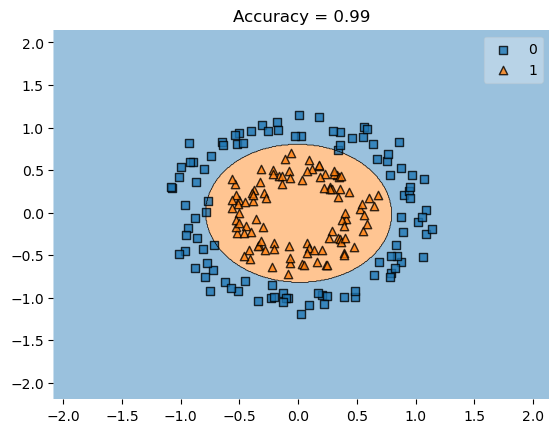

In [32]:
plr = poly_LR(degree = 2)
plr.fit(X, y)
viz_plr(plr, X, y)

Let's check the coefficients of the model: 

In [ ]:
#

Notice that two coefficients are much larger than the others, and approximately equal. These are the coefficients for the features $x_1^2$ and $x_2^2$. The fact that these are approximately equal means that our model is very close to using the square radius $r^2 = x_1^2 + x_2^2$ for this data, just like we'd expect. The benefit is that we didn't have to hard-code that in; the model just detected on its own the right pattern to find. 

Part of the reason this might be beneficial is that for some data sets, we might not really know what specific features we should try. For example, here's another one where a linear classifier doesn't do so great (degree 1 corresponds to no transformation of the features).  

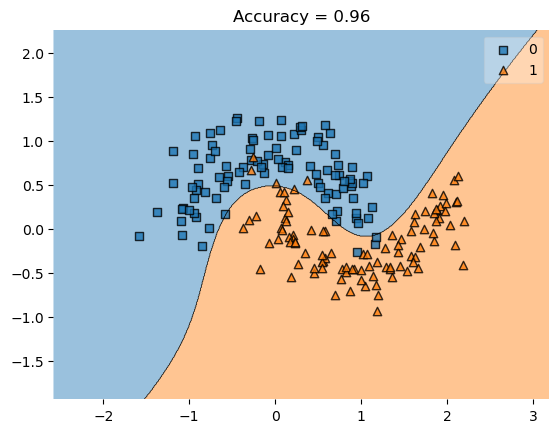

In [39]:
np.random.seed(123)
X, y = make_moons(200, shuffle = True, noise = 0.2)

plr = poly_LR(degree = 5)
plr.fit(X, y)
viz_plr(plr, X, y)

In [40]:
plr.named_steps["LR"].coef_

array([[-2.55579727e-05,  1.35298953e-01, -2.50514385e+00,
        -2.60266667e+00, -8.30713930e-01, -6.30431140e-01,
        -1.22029940e-01, -1.25686564e+00,  2.00495256e-01,
        -9.53134307e-01, -8.86217141e-01, -5.66003771e-01,
        -1.31942269e-01, -2.17573278e-01, -4.71614719e-01,
         1.47754692e+00, -7.21316467e-01,  1.89326224e-01,
        -3.17134507e-01,  1.37450850e-02, -5.02202198e-01]])

It's not as obvious that we should use the radius or any other specific feature for our feature map. Fortunately we don't need to think too much about it -- we can just increase the degree and let the model figure things out: 

In [ ]:
# 
# 
#

Much nicer! 

## Generalization, Feature Selection, Regularization

So, why don't we just use as many features as it takes to get perfect accuracy on the training data? Here's an example where we get perfect accuracy on the training data: 

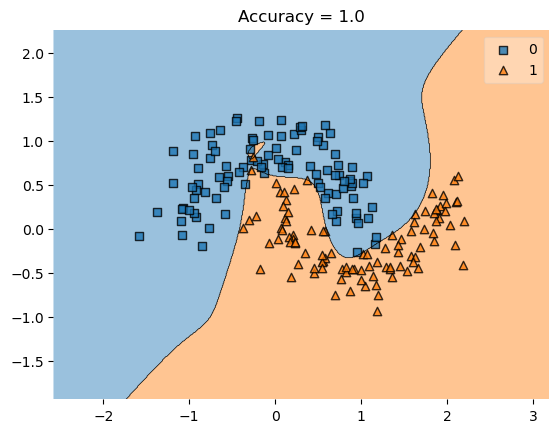

In [41]:
plr = poly_LR(degree = 15, penalty = "none", max_iter = 1e6)
plr.fit(X, y)
viz_plr(plr, X, y)

I've had to change some parameters to the `LogisticRegression` in order to ensure that it fully ran the optimization procedure for this many polynomials. 

The problem here is that, although this classifier might achieve perfect *training* accuracy, it doesn't really look like it's captured "the right" pattern. This means that if we ask it to classify *similar* new data, it's unlikely to do as well: 

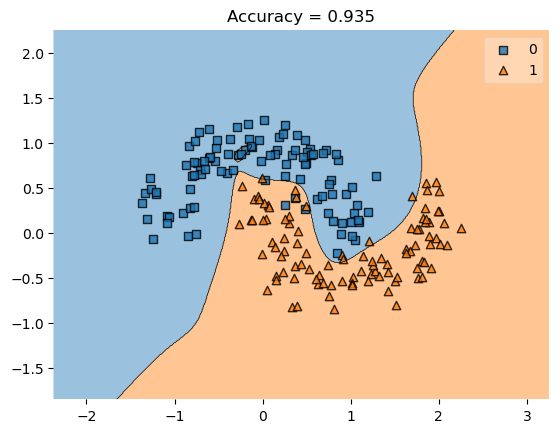

In [42]:
X, y = make_moons(200, shuffle = True, noise = 0.2)
viz_plr(plr, X, y)

Whoops! We have *overfit*: our model was so flexible that it was able to learn both some *real* patterns that we wanted it to learn and some *noise* that we didn't. As a result, when it made a prediction on new data, the model's predictions were imperfect, reflecting the noise it learned in the training process. 

In machine learning practice, we don't actually *want* our models to get perfect scores on the training data -- we want them to ***generalize*** to new instances of unseen data. Overfitting is one way in which a model can fail to generalize. 

Let's do an experiment in which we see what happens to the model's generalization ability when we increase the number of polynomial features: 


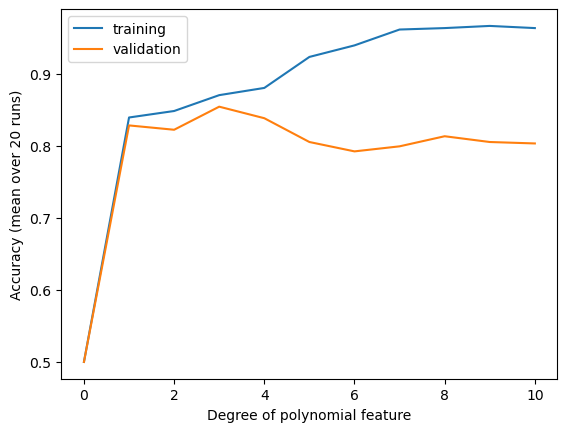

In [43]:
import pandas as pd
np.random.seed()

degs = range(0, 11)

df = pd.DataFrame({"deg": [], "train" : [], "test" : []})

for rep in range(10):
    X_train, y_train = make_moons(100, shuffle = True, noise = .4)
    X_test, y_test = make_moons(100, shuffle = True, noise = .4)

    for deg in degs:
        plr = poly_LR(degree = deg, penalty = "none", max_iter = 1e3)
        plr.fit(X_train, y_train)

        to_add = pd.DataFrame({"deg" : [deg],
                               "train" : [plr.score(X_train, y_train)],
                               "test" : [plr.score(X_test, y_test)]})

        df = pd.concat((df, to_add))
        
means = df.groupby("deg").mean().reset_index()

plt.plot(means["deg"], means["train"], label = "training")
plt.plot(means["deg"], means["test"], label = "validation")
plt.legend()
labs = plt.gca().set(xlabel = "Degree of polynomial feature",
              ylabel = "Accuracy (mean over 20 runs)")

We observe that there is an optimal number of features for which the model is most able to generalize: around 3 or so. More features than that is actually *harmful* to the model's predictive performance. 

So, one way to promote generalization is to try to find "the right" or "the right number" of features and use them for prediction. This problem is often called **feature selection**. 

Another common approach to avoid overfitting is called *regularization*. In regularization, we actually modify the empirical risk objective function that is to be minimized. Instead of trying to minimize @eq-empirical-risk-minimization, we instead consider the modified objective function 
$$
L'(\vw) = L(\vw) + \lambda R(\vw)\;,
$$
where $\lambda$ is a *regularization strength* and $R(\vw)$ is a *regularization function* that aims to influence the entries of $\vw$ in some way. Common choices of regularization function include the Euclidean norm $R(\vw) = \norm{\vw}_2^2$ and the $\ell_1$ norm $R(\vw) = \sum_{j = 1}^p \abs{x_j}$. To see regularization in action, let's go back to our logistic regression model with a large number of polynomial features. We can see the presence of overfitting in the excessive "wiggliness" of the decision boundary. 

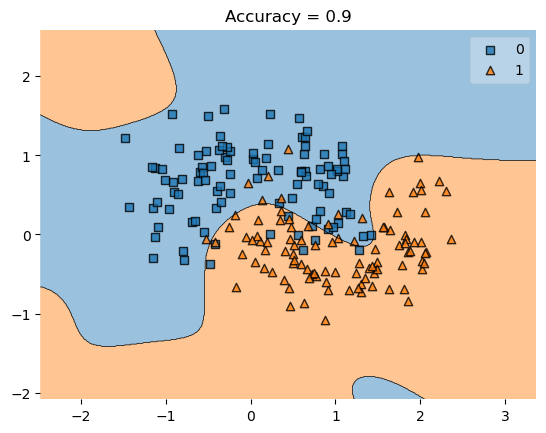

In [47]:
X, y = make_moons(200, shuffle = True, noise = 0.3)

plr = poly_LR(degree = 15, penalty = "l1", solver = "liblinear", max_iter = 1e4, C = 10)
plr.fit(X, y)
viz_plr(plr, X, y)

Fortunately for us, we can actually use regularization directly from inside the `scikit-learn` implementation of `LogisticRegression`. We specify the penalty (the $\ell_1$ regularization), the strength of the penalty (in the `scikit-learn` implementation, you specify $C = \frac{1}{\lambda}$ so that larger $C$ means less regularization) and the optimization solver (not all solvers work with all penalties).  

In [ ]:
#
#
#

This looks more likely to generalize! We can also increase the regularization: 

In [ ]:
#
#
#

or decrease it: 

In [ ]:
#
#
#

Like last time, we can conduct a search (often called a grid-search) to find the best value of the regularization strength for a given problem. We'll hold fixed the number of features, and instead vary the regularization strength:  

In [ ]:
np.random.seed()

C = 10.0**np.arange(-4, 5)

df = pd.DataFrame({"C": [], "train" : [], "test" : []})

for rep in range(10):
    X_train, y_train = make_moons(100, shuffle = True, noise = .3)
    X_test, y_test = make_moons(100, shuffle = True, noise = .3)

    for c in C:
        plr = poly_LR(degree = 15, penalty = "l1", solver = "liblinear", C = c)

        plr.fit(X_train, y_train)

        to_add = pd.DataFrame({"C" : [c],
                               "train" : [plr.score(X_train, y_train)],
                               "test" : [plr.score(X_test, y_test)]})

        df = pd.concat((df, to_add))
     
means = df.groupby("C").mean().reset_index()

plt.plot(means["C"], means["train"], label = "training")
plt.plot(means["C"], means["test"], label = "validation")
plt.semilogx()
plt.legend()
labs = plt.gca().set(xlabel = "C",
              ylabel = "Accuracy (mean over 20 runs)")

Using 15 features, it looks like a regularization strength of approximately $C = 10$ is a good choice for this problem.  